# Tahoe Quantum Wildfire Response

## 1. Introduction

Wildfires pose an increasingly severe global threat, as highlighted by recent major fires such as the 2024 Davis Fire near Reno and devastating events in Los Angeles and Maui. These incidents underscore critical gaps in current wildfire management strategies. Effective disaster response requires rapid and optimal allocation of limited resources—including firefighters, equipment, water supplies, and evacuation logistics—to protect communities, minimize destruction, and ultimately save lives. Additionally, real-time monitoring of wildfire progression is challenging, as fires can spread unpredictably and rapidly.

Quantum computing offers groundbreaking capabilities to address these complex resource allocation and wildfire monitoring challenges. By efficiently navigating vast and dynamic decision spaces, quantum computing techniques—specifically Quantum Annealing and the Quantum Approximate Optimization Algorithm (QAOA)—provide powerful tools for optimizing emergency response.

Two specific classes of problems naturally arise in wildfire management scenarios:

1. **Resource Allocation**, which can be framed as a Quadratic Unconstrained Binary Optimization (QUBO) problem. This formulation helps optimize how limited resources (personnel, equipment, water supplies, etc.) are distributed to ensure they are deployed where most critically needed.

2. **Wildfire Monitoring**, which can be modeled as a Maximum Independent Set (MIS) problem. Representing critical monitoring points as nodes in a graph, the MIS approach identifies optimal, non-overlapping locations for effective surveillance.

This notebook introduces you to quantum computing tools and techniques suited to these problems. Much of your work in this hackathon will involve developing and extending the provided examples, identifying meaningful real-world problems, and applying quantum solutions to them. The examples included here serve as a starting point. Helpful resources are provided at the end of the notebook to guide you as you develop your solutions.

## 2. Logistics

The challenge and associated files are located in this [GitHub repository](https://github.com/TahoeQuantum/WildfireChallenge2025.git). You may complete the challenge and run your code on any platform of your choosing. We provide access to Qbraid's platform as a place in which you can run this notebook and do your simulations. ***Using Qbraid is not required***, but it is an option that is available to you. Qbraid provides an environment that is already configured to run this notebook, and provides the ability to submit jobs to actual quantum computers! Instructions on how to get set up with Qbraid are in the file called [qbraid_instructions](qbraid_instructions.ipynb). If you choose not to use Qbraid, a list of requirements to run this notebook are given [here](environment.yml).

## 3. Technical Introduction to QUBO

Quadratic Unconstrained Binary Optimization (QUBO) is a powerful framework used to express complex optimization problems in a compact, mathematical form. In a QUBO formulation, the goal is to minimize a quadratic function of binary variables. This framework is especially useful for problems like resource allocation, where decisions (e.g., whether or not to allocate a resource) can be naturally modeled as binary variables (0 for no allocation, 1 for allocation).

In a QUBO model, the optimization problem is expressed as:

$$
\text{minimize } x^T Q x
$$

where $x$ is a vector of binary variables and $Q$ is a matrix encoding the interactions between variables. Each entry in $Q$ represents the weight of the interaction between two decision variables. The challenge is to choose the values of $x$ such that the overall objective function is minimized.


#### Using PyQUBO
PyQUBO is a package installed in Python which allows you to formulate QUBO problems easily. Below is a simple Python example using the PyQUBO library, which demonstrates how to define a QUBO problem and convert it into a form suitable for a quantum annealer.

In [12]:
from pyqubo import Binary

# Define binary variables
x = Binary('x')
y = Binary('y')

# Define a simple QUBO model:
# Let's minimize the function: f(x, y) = 1*x + 2*y - 2*x*y
H = 1 * x + 2 * y - 2 * x * y

# Compile the model into a QUBO form
model = H.compile()
qubo, offset = model.to_qubo()

print("QUBO Matrix:")
for term, coeff in qubo.items():
    print(f"{term}: {coeff}")

print("\nOffset:", offset)

# Note: In a full resource allocation problem, the QUBO model would be significantly more complex,
# involving many more variables and constraints.

QUBO Matrix:
('x', 'x'): 1.0
('y', 'y'): 2.0
('x', 'y'): -2.0

Offset: 0.0


Now we show how to convert a real problem into a QUBO statement.

#### Toy Example: Optimal Sensor Placement

Consider a simple grid with four candidate sensor sites arranged in a square. Label the sites as A, B, C, and D:

- **A:** Top-left
- **B:** Top-right
- **C:** Bottom-left
- **D:** Bottom-right

Assume that:
- Sites A and B are too close.
- Sites A and C are too close.
- Sites B and D are too close.
- Sites C and D are too close.

Our goal is to select as many sites as possible (to maximize coverage) while ensuring that no two adjacent sites are chosen simultaneously.

To express this in a QUBO, we define:
- **Objective Term:** We want to maximize the number of sensors, which is equivalent to minimizing the negative sum of sensor selections.
- **Penalty Term:** For each pair of adjacent sites, we add a penalty if both are selected.

The resulting QUBO objective function is:

$$
H = - (A + B + C + D) + \text{penalty} \times (A \cdot B + A \cdot C + B \cdot D + C \cdot D)
$$

Below is a Python implementation using the PyQUBO library.


In [13]:
# Define binary variables for the four candidate sensor sites.
A = Binary('A')
B = Binary('B')
C = Binary('C')
D = Binary('D')

# Penalty weight to discourage placing sensors too close together.
penalty = 2

# Define the QUBO objective:
# - We want to maximize sensor deployment (- (A+B+C+D))
# - We add a penalty for each pair of adjacent sensors.
H = - (A + B + C + D) + penalty * (A * B + A * C + B * D + C * D)

# Compile the model into QUBO form.
model = H.compile()
qubo, offset = model.to_qubo()

print("QUBO Matrix:")
for term, coeff in qubo.items():
    print(f"{term}: {coeff}")

print("\nOffset:", offset)

QUBO Matrix:
('A', 'A'): -1.0
('D', 'C'): 2.0
('D', 'B'): 2.0
('C', 'A'): 2.0
('D', 'D'): -1.0
('A', 'B'): 2.0
('C', 'C'): -1.0
('B', 'B'): -1.0

Offset: 0.0


Here’s how to read these coefficients:

1. **Diagonal Terms (e.g., `('A', 'A'): -1.0`)**  
   - These represent the linear coefficients for individual variables.  
   - A value of `-1.0` for `('A', 'A')` means that the variable `A` contributes `-1.0 * A` to the objective.  
   - In this toy problem, we have negative diagonal terms because we want to **encourage** the selection of each sensor site (i.e., we are maximizing the number of chosen sites by minimizing a negative sum).

2. **Off-Diagonal Terms (e.g., `('A', 'B'): 2.0`)**  
   - These represent the interaction terms between two different variables.  
   - A value of `2.0` for `('A', 'B')` means there is a penalty of `2.0 * A * B` if **both** `A` and `B` are set to 1.  
   - In this toy example, `2.0` is the penalty weight we assigned to discourage placing sensors at two locations (`A` and `B`) that are too close together.  
   - The same logic applies to other off-diagonal pairs like `('D', 'B')`, `('C', 'A')`, etc.

3. **Offset (e.g., `Offset: 0.0`)**  
   - This is a constant term added to the objective function.  
   - In this case, it’s `0.0`, indicating there’s no constant offset in the QUBO.

Putting it all together, the matrix shows how each pair of variables contributes to the objective function. Negative diagonal entries encourage selecting sensors, while positive off-diagonal entries penalize placing sensors in locations that are too close to each other. The solver’s job is to find binary values for each variable (`A`, `B`, `C`, `D`) that minimize the total energy of this QUBO—ultimately striking a balance between choosing as many sensors as possible and avoiding adjacent placements. Note we haven't actaully solved this QUBO problem, we just reframed our toy problem in a QUBO framework. We will next show how to use Quantum Annealing and QAOA to solve the QUBO problem. 

## 4. Quantum Annealing for Solving QUBO


Quantum annealing is a specialized quantum computing method designed to solve **combinatorial optimization problems**, particularly those formulated as **Quadratic Unconstrained Binary Optimization (QUBO)** problems.

Quantum annealing approaches this by mapping the QUBO function onto a **quantum Hamiltonian**—a mathematical object representing the energy of a physical system. The system is initialized in the ground state of a simple Hamiltonian $H_0$, and slowly evolved into the Hamiltonian representing your QUBO problem, $H_P$.

This evolution is governed by a time-dependent Hamiltonian:

$H(t) = (1 - s(t)) H_0 + s(t) H_P$

where:
- $s(t)$ is a schedule function increasing from 0 to 1 over time $t$,
- $H_0$ is the initial “driver” Hamiltonian that is easy to prepare,
- $H_P$ is the **problem Hamiltonian** encoding the QUBO objective.

If the system evolves slowly enough (following the **adiabatic theorem**), it will remain in the ground state of the changing Hamiltonian and end in the ground state of $H_P$—which corresponds to the **optimal solution** of the original QUBO.

This means that we can use quantum annealers (simulators) to solve our QUBO problem, by starting with a simple Hamiltonian and slowly evolving to our desired Hamiltonian with all of the constraints. 

### Annealing Simulation
We now show you how to use an annealing simulator to solve the QUBO problem you've formulated. This is just one way to solve an annealing problem in Python, so feel free to use other methods if you have them. 

In [14]:
import neal

# We will use the QUBO we defined in the previous python cell.

# Initialize the simulated annealing sampler
sampler = neal.SimulatedAnnealingSampler()

# Solve the QUBO problem using the sampler with a specified number of reads.
# The more reads, the better the chance to find a lower energy solution.
sampleset = sampler.sample_qubo(qubo, num_reads=100)

# Extract and display the best solution found
best_solution = sampleset.first.sample
best_energy = sampleset.first.energy

print("Best Solution:")
print(best_solution)
print("Energy of the Best Solution:")
print(best_energy)

# Optionally, print the complete sample set to review all candidate solutions.
# print("\nComplete Sample Set:")
# print(sampleset)

Best Solution:
{'A': np.int8(1), 'B': np.int8(0), 'C': np.int8(0), 'D': np.int8(1)}
Energy of the Best Solution:
-2.0


For our toy problem, the annealer returned that we should place sensors on B and C, matching our intuition.

## 5. QAOA to solve QUBO

The **Quantum Approximate Optimization Algorithm (QAOA)** is a variational algorithm designed to solve combinatorial optimization problems, particularly those that can be written in **QUBO (Quadratic Unconstrained Binary Optimization)** form. It is a **gate-based algorithm** and can run on noisy quantum hardware. It is easier to map our QUBO onto a set of Rydberg atoms, and then do QAOA on the Rydberg atom problem. Let's first explain what QAOA is:

### Understanding QAOA
QAOA constructs a **parametrized quantum circuit** that prepares a quantum state encoding good (low-cost) solutions to a given optimization problem. The goal is to **maximize** the probability of measuring a bitstring that minimizes the original cost function.

A QUBO problem can be written as:

$$Q(x) = \sum_i Q_{ii} x_i + \sum_{i<j} Q_{ij} x_i x_j$$

where $x_i \in \{0,1\}$ are binary variables. This is equivalent to finding the ground state (minimum eigenvalue state) of the **problem Hamiltonian**:

$$H_P = \sum_i h_i Z_i + \sum_{i<j} J_{ij} Z_i Z_j$$

Here, we map $x_i \in \{0,1\}$ to qubit states via $x_i = \frac{1 - Z_i}{2}$, where $Z_i$ is the Pauli-Z operator acting on qubit $i$

QAOA prepares the quantum state through alternating applications of:

1. **Cost Unitaries** generated by $H_P$:
   $$U_C(\gamma) = e^{-i \gamma H_P}$$

2. **Mixer Unitaries** that allow transitions between bitstrings:
   $$U_M(\beta) = e^{-i \beta H_M}$$

The mixer Hamiltonian is usually:

$$H_M = \sum_i X_i$$

where $X_i$ is the Pauli-X operator on qubit $i$. The QAOA state after $p$ layers (also called *reps*) is:

$$|\psi(\vec{\gamma}, \vec{\beta})\rangle = U_M(\beta_p) U_C(\gamma_p) \cdots U_M(\beta_1) U_C(\gamma_1) |\psi_0\rangle$$

with $$|\psi_0\rangle = \frac{1}{\sqrt{2^n}} \sum_{x} |x\rangle$$ as the uniform superposition. The parameters $\vec{\gamma}, \vec{\beta}$ are **optimized classically** to minimize:

$$\langle \psi(\vec{\gamma}, \vec{\beta}) | H_P | \psi(\vec{\gamma}, \vec{\beta}) \rangle$$

### Mapping QUBO to Rydberg atoms


### Our implementation
Mapping the QUBO problem onto a Rydberg atom register involves embedding the problem's structure into the physical arrangement and interactions of neutral atoms. The Rydberg blockade effect ensures that only one atom in a pair can be excited, which can be leveraged to represent the problem's constraints. We recommend you spend some time here learning more about how neutral atom quantum computers work. 

Given that we have a QUBO matrix Q, we can now proceed to map it onto a Rydberg atom lattice, and then use QAOA to solve the problem. This is done in the Pulser documentation, and we will reproduce it here as an example. More details can be found [here](https://pulser.readthedocs.io/en/latest/tutorials/qubo.html)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser.devices import DigitalAnalogDevice
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

Q = np.array(
    [
        [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
        [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
        [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
        [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
        [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
    ]
)

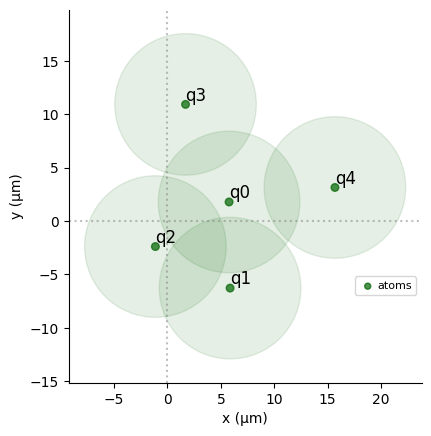

In [18]:
def evaluate_mapping(new_coords, Q):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    return np.linalg.norm(new_Q - Q)

costs = []
np.random.seed(0)
x0 = np.random.random(len(Q) * 2)
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q,),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))

qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = Register(qubits)
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True)

In [19]:
LAYERS = 2

# Parametrized sequence
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ch0", "rydberg_global")

t_list = seq.declare_variable("t_list", size=LAYERS)
s_list = seq.declare_variable("s_list", size=LAYERS)

for t, s in zip(t_list, s_list):
    pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
    pulse_2 = Pulse.ConstantPulse(1000 * s, 0.0, 1.0, 0)

    seq.add(pulse_1, "ch0")
    seq.add(pulse_2, "ch0")

seq.measure("ground-rydberg")

## 6. Recap and Challenge Statement
Phew, we've given you a lot of tools and things to learn about! Let's quickly recap what we've done so far, and then proceed with the challenge statement. There are two types of problems we've considered so far, resource allocation problems (which can be easily formulated as QUBO problems), and wildfire monitoring problems (which can be formulated as MIS problems, and then converted to QUBO). Here's what we want you to do:
1. Understand the physics, math, and intuition behind QUBO, Quantum Annealing, and QAOA
2. Create a resource allocation problem statement that a Fire Chief would face when dealing with an active wildfire, or a wildfire monitoring problem formulated as a MIS statement. Then, rewrite your problem using the QUBO formalism (note: we haven't gone through how to write an MIS problem as a QUBO statement, but there are useful resources in the links at the bottom that will help with this!)
3. By either using a quantum annealing simulator, or the mapping to Rydberg atoms and QAOA solver (or both!), solve the QUBO problem that you formulated and interpret the results.
4. Optional: Come up with a new problem that you think firefighters face when addressing wildfires and justify its importance. Then use the tools we've discussed to solve it
5. Optional: Use the Qbraid platform to run your problem on an actual quantum computer! 

This challenge has a lot of components. We don't expect you to complete each and every part (for example, you can choose to focus on quantum annealers rather than QAOA to solve your QUBO problems). We want to see you attempt and solve as many parts as you can, with emphasis placed on being creative when coming up with new problems and applying the tools you've learned. 

**Deliverables:**
1. ***Presentation*** of your work
2. ***Writeup*** of your solution
3. ***Annotated iPython notebook*** containing any simulations or work you want considered. 

### 7. Judging Criteria
We will judge your work based on the following critera, with the percentages showing their relative importance:
| Criterion                                | Weight |
|-----------------------------------------|--------|
| **Technical Implementation and use of Quantum Tools** | 30%    |
| **Correctness & Practicality**          | 30%    |
| **Creativity** | 20% |
| **Presentation**   | 10%    |
| **Writeup and Notebook**                 | 10%    |


### 8. Resources
**QUBO:**
https://arxiv.org/pdf/1811.11538

https://pyqubo.readthedocs.io/en/latest/getting_started.html

**Quantum Annealing**
https://arxiv.org/abs/1006.1696

https://arxiv.org/abs/1801.08653

https://docs.dwavequantum.com/en/latest/index.html

**QAOA**
https://arxiv.org/abs/1602.07674

https://pennylane.ai/qml/demos/tutorial_QUBO

https://pulser.readthedocs.io/en/latest/tutorials/qubo.html 

**MIS**
https://ieeexplore.ieee.org/document/8477865

https://www.nature.com/articles/s41597-024-02926-9
